<a href="https://colab.research.google.com/github/mukamal/predicting-diamond-prices-lr/blob/main/predicting_diamond_prices_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Diamond Prices using Linear Regression

In [1]:
%%bash

# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download tweets.csv from github
# If the tweets.csv file does not exist in the colab environment
if [[ ! -f ./tweets.csv ]]; then 
   # download tweets.csv file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/mukamal/data/main/diamonds.csv   
fi

# vefify tweets.csv exits in the colab env - should not print an error message
ls diamonds.csv 

diamonds.csv


--2021-04-23 01:31:38--  https://raw.githubusercontent.com/mukamal/data/main/diamonds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3192560 (3.0M) [text/plain]
Saving to: ‘diamonds.csv.1’

     0K .......... .......... .......... .......... ..........  1% 3.79M 1s
    50K .......... .......... .......... .......... ..........  3% 8.43M 1s
   100K .......... .......... .......... .......... ..........  4% 4.93M 1s
   150K .......... .......... .......... .......... ..........  6% 19.0M 0s
   200K .......... .......... .......... .......... ..........  8% 6.34M 0s
   250K .......... .......... .......... .......... ..........  9% 25.6M 0s
   300K .......... .......... .......... .......... .......... 11% 24.1M 0s
   350K .......... .......... .......... 

In [2]:
# import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Diamonds Data
This notebook will use a diamonds dataset to explore spark pipelines, linear regression, feature transformation, model scoring, inference, and feature selection.

The diamonds.csv data set contains 10 columns:
- carat: Carat weight of the diamond
- cut: Describes cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal
- color: Color of the diamond, with D being the best and J the worst
- clarity: How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, etc.  See this web site for an exhaustive ranking of [clarity](https://4cs.gia.edu/en-us/diamond-clarity/?gclid=Cj0KCQjwnqH7BRDdARIsACTSAduMoc2KQbXkO94BxCfBNC5X8YyjAYcFpWThKQMW46cQj_3p0pZ0o84aAuagEALw_wcB).  The web site has a nice sliding scale you can drag to see the relationship between clarity grades.
- depth: depth % - The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
- table: table% -  The width of the diamond's table expressed as a percentage of its average diameter
- price: The price of the diamond
- x: Length (mm)
- y: Width (mm)
- z: Height (mm)

Read the diamonds.csv file into a spark data frame named `diamonds_df`.

In [3]:
diamonds_df = spark.read.format("csv").option("header", "true").load("diamonds.csv")
diamonds_df.take(5)

[Row(_c0='1', carat='0.23', cut='Ideal', color='E', clarity='SI2', depth='61.5', table='55', price='326', x='3.95', y='3.98', z='2.43'),
 Row(_c0='2', carat='0.21', cut='Premium', color='E', clarity='SI1', depth='59.8', table='61', price='326', x='3.89', y='3.84', z='2.31'),
 Row(_c0='3', carat='0.23', cut='Good', color='E', clarity='VS1', depth='56.9', table='65', price='327', x='4.05', y='4.07', z='2.31'),
 Row(_c0='4', carat='0.29', cut='Premium', color='I', clarity='VS2', depth='62.4', table='58', price='334', x='4.2', y='4.23', z='2.63'),
 Row(_c0='5', carat='0.31', cut='Good', color='J', clarity='SI2', depth='63.3', table='58', price='335', x='4.34', y='4.35', z='2.75')]

In [4]:

diamonds_df = diamonds_df.drop('_c0')


In [5]:
display(diamonds_df.toPandas().head())

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58,334,4.2,4.23,2.63
4,0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75


Investigate the diamond data.  Create a pair plot on the real data columns which sumarizes the data. In addition to the pair plot, use a spark dataframe built in function to provide a statistical summary of the data.

  summary               carat  ...                   y                   z
0   count               53940  ...               53940               53940
1    mean  0.7979397459442544  ...   5.734525955793015  3.5387337920972493
2  stddev   0.474011242836904  ...  1.1421346736743894   0.705698843275196
3     min                 0.2  ...                 0.0                 0.0
4     max                5.01  ...                58.9                31.8

[5 rows x 8 columns]
+---------+-----+
|      cut|count|
+---------+-----+
|  Premium|13791|
|    Ideal|21551|
|     Good| 4906|
|     Fair| 1610|
|Very Good|12082|
+---------+-----+

+-----+-----+
|color|count|
+-----+-----+
|    F| 9542|
|    E| 9797|
|    D| 6775|
|    J| 2808|
|    G|11292|
|    I| 5422|
|    H| 8304|
+-----+-----+

+-------+-----+
|clarity|count|
+-------+-----+
|   VVS2| 5066|
|    SI1|13065|
|     IF| 1790|
|     I1|  741|
|   VVS1| 3655|
|    VS2|12258|
|    SI2| 9194|
|    VS1| 8171|
+-------+-----+



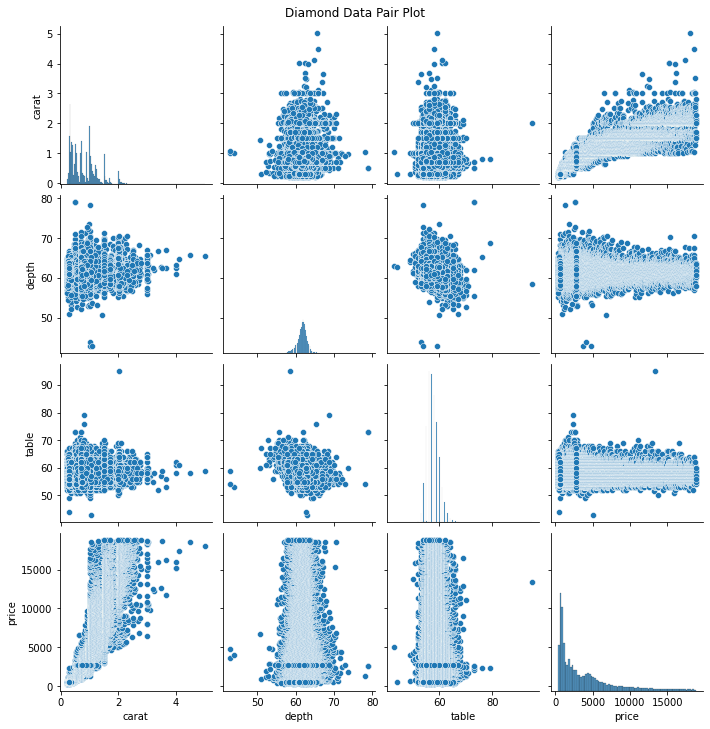

In [6]:
import seaborn as sns
from pyspark.sql.types import FloatType

from pyspark.sql.functions import isnan, isnull, when, count, col

#diamonds_df.select([count(when(isnull(c), c)).alias(c) for c in diamonds_df.columns]).show()
#diamonds_df.select([count(when(isnan(c), c)).alias(c) for c in diamonds_df.columns]).show()


diamonds_df = diamonds_df.withColumn("carat", diamonds_df["carat"].cast(FloatType()))
diamonds_df = diamonds_df.withColumn("depth", diamonds_df["depth"].cast(FloatType()))
diamonds_df = diamonds_df.withColumn("table", diamonds_df["table"].cast(FloatType()))
diamonds_df = diamonds_df.withColumn("price", diamonds_df["price"].cast(FloatType()))

diamonds_df = diamonds_df.withColumn("x", diamonds_df["x"].cast(FloatType()))
diamonds_df = diamonds_df.withColumn("y", diamonds_df["y"].cast(FloatType()))
diamonds_df = diamonds_df.withColumn("z", diamonds_df["z"].cast(FloatType()))

ax = sns.pairplot(diamonds_df.toPandas()[['carat', 'depth','table','price']])
ax.fig.suptitle("Diamond Data Pair Plot",  y=1.01)

print(diamonds_df.select('carat', 'depth','table','price','x','y','z').describe().toPandas())

diamonds_df.groupBy("cut").count().show()
diamonds_df.groupBy("color").count().show()
diamonds_df.groupBy("clarity").count().show()


Looking at the label columns of 'cut', 'color' and clarity, we see an evenly distrubted data.
Looking at the pairplots, it is difficult to see a clear correlation other than price vs carat plot, where an increase in carat seems to correlate with increase in price.
Looking at the mean (0.79) and max (5.01) value of 'carat', it seems the column may be right skewed.
The minimun values of x,y and z as 0, seems problametic though. However, i am going assume that values were small enough to be rounded off as 0. 

There are one or more columns of data in diamonds_df which are not in an appropriate format for performing linear regression.  Perform feature engineering on all columns which are not in a format which is ready for use in a linear regression model.

Create a new data frame named `diamonds_df_xformed` which contains the same number of columns and the same column names as diamonds_df.  Transform diamonds_df such that diamonds_df_xformed is ready to feed into a linear regression model for training.  diamonds_df_xformed Shall contain new feature engineered columns that can be directly used in linear regression.

In [7]:

from pyspark.ml import feature, regression, evaluation, Pipeline

cut_i = feature.StringIndexerModel.from_labels(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
                                    inputCol="cut",
                                    outputCol="cut_idx")

col_i = feature.StringIndexerModel.from_labels(['J', 'I', 'H','G','F', 'E', 'D'],
                                    inputCol="color",
                                    outputCol="color_idx")
clar_i = feature.StringIndexerModel.from_labels(['I1', 'SI2', 'SI1', 'VS2','VS1','VVS2','VVS1','IF'],
                                    inputCol="clarity",
                                    outputCol="clarity_idx")


feature_engineering_pipe=Pipeline(stages=[cut_i, col_i, clar_i])

diamonds_df_xformed = feature_engineering_pipe.fit(diamonds_df).transform(diamonds_df)
drop_cols = ['color', 'cut','clarity']
diamonds_df_xformed = diamonds_df_xformed.\
    drop(*drop_cols)


diamonds_df_xformed = diamonds_df_xformed.withColumnRenamed("color_idx", "color")\
                        .withColumnRenamed("cut_idx", "cut")\
                        .withColumnRenamed("clarity_idx", "clarity")


In [8]:
display(diamonds_df_xformed.toPandas().head())

,carat,depth,table,price,x,y,z,cut,color,clarity
0,0.23,61.500000,55.0,326.0,3.95,3.98,2.43,4.0,5.0,1.0
1,0.21,59.799999,61.0,326.0,3.89,3.84,2.31,3.0,5.0,2.0
2,0.23,56.900002,65.0,327.0,4.05,4.07,2.31,1.0,5.0,4.0
3,0.29,62.400002,58.0,334.0,4.20,4.23,2.63,3.0,1.0,3.0
4,0.31,63.299999,58.0,335.0,4.34,4.35,2.75,1.0,0.0,1.0


First, I converted all numeric variables from string to float. 

Then I tranformed all categorical variables into numericalvaribles so that they can be used for linear regression and encapsulated into a spark pipeline. Then i dropped the original columns andd renamed the new columns such that all columns have the same name name as the original dataframe.


Create a new pipeline named `diamond_pipe`. 

Train and test diamond_pipe on the diamonds_df_xformed data frame using price as the target.

In [9]:

#forward stepseletion 
from pyspark.ml import classification
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row


training_df, validation_df, testing_df = diamonds_df_xformed.randomSplit([0.7, 0.1, 0.2], )
print([training_df.count(), validation_df.count(), testing_df.count()])

va1 = feature.VectorAssembler(inputCols=['carat', 'depth', 'table','cut','color','clarity'], outputCol='features')
va2= feature.VectorAssembler(inputCols=['carat', 'depth', 'table','cut','color','clarity','x','y','z'], outputCol='features')

diamond_pipe=regression.LinearRegression(featuresCol='features',labelCol='price')

model1 = Pipeline(stages=[va1,diamond_pipe])
model2 = Pipeline(stages=[va2,diamond_pipe])


model1_fitted = model1.fit(training_df)
model2_fitted = model2.fit(training_df)

mse = fn.mean((fn.col('price') - fn.col('prediction'))**2).alias('mse')

print("Model1 train mse:")
model1_fitted.transform(training_df).select(mse).show()
print("Model1 validation mse:")
model1_fitted.transform(validation_df).select(mse).show()
print("Model1 test mse:")
model1_fitted.transform(testing_df).select(mse).show()

print("Model2 train mse:")
model2_fitted.transform(training_df).select(mse).show()
print("Model2 validation mse:")
model2_fitted.transform(validation_df).select(mse).show()
print("Model2 test mse:")
model2_fitted.transform(testing_df).select(mse).show()


[37667, 5454, 10819]
Model1 train mse:
+------------------+
|               mse|
+------------------+
|1544689.2929402643|
+------------------+

Model1 validation mse:
+------------------+
|               mse|
+------------------+
|1467432.7371557849|
+------------------+

Model1 test mse:
+------------------+
|               mse|
+------------------+
|1469364.0739948587|
+------------------+

Model2 train mse:
+------------------+
|               mse|
+------------------+
|1508734.1181827337|
+------------------+

Model2 validation mse:
+-----------------+
|              mse|
+-----------------+
|1418097.685761551|
+-----------------+

Model2 test mse:
+------------------+
|               mse|
+------------------+
|1415846.6746444404|
+------------------+



Repeat above steps only this time score the model using 3-fold cross validation using an empty parameter grid. Print the resulting score from 3 fold cross validation. 

In [10]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator


paramGrid = ParamGridBuilder() \
    .addGrid(diamond_pipe.elasticNetParam, [0., 0.01, 0.1]) \
    .addGrid(diamond_pipe.regParam, [0.1, 0.01, 0.001, 0.0001]) \
    .build()


crossval = CrossValidator(estimator=model1, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=RegressionEvaluator(labelCol='price'), 
                          numFolds=3)


# Run cross validations
final_model_fitted = crossval.fit(training_df)
print(final_model_fitted)

# Get Model Summary Statistics
final_model_fitted.bestModel.stages[1]
final_model_fitted.avgMetrics

CrossValidatorModel_86432ec7b53d


[1243.063309215136,
 1243.063304086913,
 1243.0633042234158,
 1243.063304243561,
 1243.0633090804033,
 1243.0633036893985,
 1243.0633032175444,
 1243.0633041690432,
 1243.063308804098,
 1243.0633038670846,
 1243.0633038250837,
 1243.0633032376315]


Cross-Validation results in a much more robust best fitted model. Since all data is used to verify the perfomance. For e.g, during first fold, the data that is held out becomes part of training data and another portion of data is used as validation set. Whereas scoring technique in Q4  leaves out a large portion when training.

Create a new pipeline named inference_pipe which encapsulates a standard scalar and a linear regression object.

After fitting the pipe, create a pandas data frame from the fitted regression model coefficients named `coefficients_df`.  coefficients_df Shall have 2 columns named `coefficient` and `value`.  The coefficient column shall contain the coefficient names and the value column shall contain the regression model coefficient absolute values.  Provide a written explanation of what the results mean.  

In [11]:
import pandas as pd
sc = feature.StandardScaler(withMean=True, inputCol='features')
inference_pipe = Pipeline(stages=[va2,sc,diamond_pipe])
model_sc_fitted = inference_pipe.fit(training_df)

coefficients_df=model_sc_fitted.stages[2].coefficients


coeff=['carat', 'depth', 'table','cut','color','clarity','x','y','z']
coefficients_df = pd.DataFrame(data={'coefficient':coeff,'value':model_sc_fitted.stages[2].coefficients})


In [12]:
display(coefficients_df)

,coefficient,value
0,carat,10530.940017
1,depth,-77.747253
2,table,-21.048394
3,cut,131.610396
4,color,322.816030
5,clarity,504.009329
6,x,-854.152347
7,y,28.412368
8,z,93.355454


Since the training data was standardised, the coefficients of the variables are comparlable. For e.g, per unt increase in either of the variables coefficients changes the price by the value of its coefficients.

forward stepwise selection algorithm 6.2 in ISLR. The code is a partial implementation because the function specified essentially completes a single iteration of algorithm 6.2 per call. 

Create a function named `find_best_pred` that takes 3 arguments: A list of starting column names for the initial model, a list of column names to test for improvement, and the target column name.  

Use MSE as the improvement metric.  The return value is the name of the column that provides the largest MSE improvement.  If no improvement in MSE is detected, return the string 'Null'.  Starting with the starting columns, the find_best_pred function shall return the col name that produces the largest improvement in MSE.  

Check for error conditions and return the 'Null' string if there is an error in the input data.  

In [13]:

def find_best_pred(cols_names,col_test,col_target):
    
    if not col_target or not type(col_target)==str or :
        return 'NULL'
    
    if not col_test or not type(col_test)==list:
        return 'NULL'
    
    if not type(cols_names)==list:
        return 'NULL'      
        
   
    best_col='NULL'
    
    diamond_pipe=regression.LinearRegression(featuresCol='features',labelCol=col_target)
    va= feature.VectorAssembler(inputCols=cols_names, outputCol='features')
    model0 = Pipeline(stages=[va,diamond_pipe])
    model0_fitted = model0.fit(training_df)
    mse0=model0_fitted.transform(validation_df).select(mse).toPandas()['mse'][0]           
    

    for c in col_test:
        l = cols_names + [c]
        va1= feature.VectorAssembler(inputCols=l, outputCol='features')
        model1 = Pipeline(stages=[va1,diamond_pipe])
        model1_fitted = model1.fit(training_df)
        mse1=model1_fitted.transform(validation_df).select(mse).toPandas()['mse'][0]  
        
        if(mse1<mse0):
            best_col=c
            mse0=mse1  
      
    
    
    return best_col
    


In [18]:

def find_best_pred(cols_names,col_test,col_target):
    
    if not col_target or not type(col_target)==str or col_target!="price":
        return 'NULL'
    
    if not col_test or not type(col_test)==list:
        return 'NULL'
    
    if not type(cols_names)==list:
        return 'NULL'      
        
   
    best_col='NULL'
    
    diamond_pipe=regression.LinearRegression(featuresCol='features',labelCol=col_target)
    va= feature.VectorAssembler(inputCols=cols_names, outputCol='features')
    model0 = Pipeline(stages=[va,diamond_pipe])
    model0_fitted = model0.fit(training_df)
    mse0=model0_fitted.transform(validation_df).select(mse).toPandas()['mse'][0]           
    

    for c in col_test:
        l = cols_names + [c]
        va1= feature.VectorAssembler(inputCols=l, outputCol='features')
        model1 = Pipeline(stages=[va1,diamond_pipe])
        model1_fitted = model1.fit(training_df)
        mse1=model1_fitted.transform(validation_df).select(mse).toPandas()['mse'][0]  
        
        if(mse1<mse0):
            best_col=c
            mse0=mse1  
      
    
    
    return best_col
    


In [19]:
print(find_best_pred([], ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))
print(find_best_pred(['carat', 'cut'], ['color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))

carat
clarity


In [22]:
print("target in initial")
print(find_best_pred(['price'], ['color'], 'price'))

# target in test
print("target in test")
print(find_best_pred(['carat'], ['price'], 'price'))

# unknown target
print("unknown target")
print(find_best_pred(['carat'], ['color'], 'foo'))





# test col is empty
print("test col is empty")
print(find_best_pred(['carat'], [], 'price'))

# duplicate initial
print("duplicate initial")
print(find_best_pred(['carat', 'clarity', 'carat'], ['color'], 'price'))

# duplicate test
print("duplicate test")
print(find_best_pred(['color'], ['carat', 'clarity', 'carat'], 'price'))

# overlapping initial and test
print("overlapping initial and test")
print(find_best_pred(['carat'], ['carat'], 'price'))

target in initial
NULL
target in test
price
unknown target
NULL
test col is empty
NULL
duplicate initial
color
duplicate test
carat
overlapping initial and test
NULL


Complete forward stepwise selection algorithm 6.2 in ISLR.

Create a new function named `get_stepwise_pred_list` which iteratively calls find_best_pred to build an ordered list of the best stepwise features. Terminate building the list if find_best_pred returns Null or you run out of predictors to test - whichever comes first.  get_stepwise_pred_list Takes 2 arguments:  A list of all predictors and the dataset target column.   get_stepwise_pred_list Returns a list containing the ordered stepwise features selected by iteratively calling find_best_pred.  

In [23]:


def get_stepwise_pred_list(c_test,c_target):
    c=[]
    while(1):
        new_col=find_best_pred(c,c_test,c_target)
        if new_col =='NULL' or len(c)==len(c_test):
            return c
        c=c+[new_col]


In [24]:
print(get_stepwise_pred_list(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))

['carat', 'clarity', 'color', 'x', 'cut', 'depth', 'table', 'y', 'depth']
